# PARALLEL WORKFLOWS SHOULD NOT RETURN ENTRIE STATE JUST THAT KEY WITH CHANGED VALUE

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain.chat_models import init_chat_model

In [55]:
class BatsmanDetail(TypedDict):
    balls_faced: int
    runs_scored: int
    fours_hit: int
    sixes_hit: int
    
    strike_rate: float
    boundary_percentage: float
    balls_per_boundary: float
    summary: str

In [56]:
def calculate_strike_rate(state: BatsmanDetail):
    balls_faced = state['balls_faced']
    runs_scored = state['runs_scored']
    strike_rate = (runs_scored / balls_faced) * 100 if balls_faced > 0 else 0
    return {'strike_rate': strike_rate}

In [57]:
def calculate_boundary_percentage(state: BatsmanDetail):
    fours_hit = state['fours_hit']
    sixes_hit = state['sixes_hit']
    runs_scored = state['runs_scored']
    total_boundaries_runs = (fours_hit * 4) + (sixes_hit * 6)
    boundary_percentage = (total_boundaries_runs / runs_scored) * 100 if runs_scored > 0 else 0
    return {'boundary_percentage': boundary_percentage}

In [58]:
def calculate_balls_per_boundary(state: BatsmanDetail):
    balls_faced = state['balls_faced']
    fours_hit = state['fours_hit']
    sixes_hit = state['sixes_hit']
    total_boundaries = fours_hit + sixes_hit
    balls_per_boundary = (balls_faced / total_boundaries) if total_boundaries > 0 else 0
    return {'balls_per_boundary': balls_per_boundary}   

In [59]:
def generate_batsman_report(state: BatsmanDetail) -> BatsmanDetail:
    summary = {
        "balls_faced": state['balls_faced'],
        "runs_scored": state['runs_scored'],
        "fours_hit": state['fours_hit'],
        "sixes_hit": state['sixes_hit'],
        "strike_rate": state['strike_rate'],
        "boundary_percentage": state['boundary_percentage'],
        "balls_per_boundary": state['balls_per_boundary']
    }
    return {'summary': summary }

In [60]:
batsman_graph = StateGraph(BatsmanDetail)

# add node
batsman_graph.add_node('calculate_strike_rate', calculate_strike_rate)
batsman_graph.add_node('calculate_boundary_percentage', calculate_boundary_percentage)
batsman_graph.add_node('calculate_balls_per_boundary', calculate_balls_per_boundary)
batsman_graph.add_node('generate_batsman_summary', generate_batsman_report)

# add edges
batsman_graph.add_edge(START, 'calculate_strike_rate')
batsman_graph.add_edge(START, 'calculate_boundary_percentage')
batsman_graph.add_edge(START, 'calculate_balls_per_boundary')
batsman_graph.add_edge('calculate_strike_rate', 'generate_batsman_summary')
batsman_graph.add_edge('calculate_boundary_percentage', 'generate_batsman_summary')
batsman_graph.add_edge('calculate_balls_per_boundary', 'generate_batsman_summary')
batsman_graph.add_edge('generate_batsman_summary', END)


In [61]:
batsman_workflow = batsman_graph.compile()

In [62]:
initial_state = {
    'balls_faced': 120,
    'runs_scored': 85,
    'fours_hit': 8,
    'sixes_hit': 2
}

In [63]:
final_state = batsman_workflow.invoke(initial_state)

In [64]:
print(final_state['summary'])

{'balls_faced': 120, 'runs_scored': 85, 'fours_hit': 8, 'sixes_hit': 2, 'strike_rate': 70.83333333333334, 'boundary_percentage': 51.76470588235295, 'balls_per_boundary': 12.0}


# LLM Workflow

In [65]:
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv, find_dotenv
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator
from langgraph.graph import StateGraph, START, END

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

True

In [71]:
gemini_model = init_chat_model("google_genai:gemini-2.5-flash")

## Using Structured Output

In [72]:
class EvalutionSchema(BaseModel):
    feedback: str = Field(description="Detailed feedback for the essay")
    score: int = Field(description="Score out of 10", ge=0, le=10)

In [73]:
structured_model = gemini_model.with_structured_output(EvalutionSchema)

In [75]:
essay = """"
AI is all about making computers do things like think or make decisions. It’s like teaching a machine how to learn from examples. For example, when you take a picture on your phone, AI helps the camera figure out who’s in the picture, like if it sees your face, or maybe even if your dog is in it. It learns by looking at lots of data and recognizing patterns. Over time, it gets better at understanding what things are. So, just like how we learn new stuff by practicing, AI can also get better the more it’s used.

AI is in a ton of stuff, even if we don’t always notice it. Some places where AI is used include phones and gadgets. Like, when you talk to Siri or Alexa, that’s AI. AI also helps make your phone camera better at taking pics and recognizing faces. It also suggests stuff you might like based on what you’ve watched or listened to before, like music or videos. Another big place AI is used is in video games. In video games, AI is used for controlling the characters you’re playing against. It makes them act like real people or creatures, so the game isn’t boring and predictable. It also makes the game harder or easier depending on how well you’re doing.

AI is also helping doctors. They use it to find diseases and decide what treatments to use. AI can look at lots of X-rays or medical reports and figure out what might be wrong. It can also help doctors do surgery with robots or give advice on the best medicine to take. Another place AI is used is in self-driving cars. This is where AI gets super cool. In self-driving cars, AI helps the car understand the world around it. It knows when to stop at traffic lights, avoid obstacles, and stay in the right lane, just like a driver would. Lastly, AI is used on social media, where it decides which posts, videos, or ads show up based on what you like or what you’ve clicked on before.

There are lots of good things about AI. One of the biggest is that it can do things much faster and more accurately than people can. For example, AI can look at millions of data points in just seconds and figure out things that would take a human forever. This can be helpful in things like healthcare, where doctors need to look at lots of test results quickly. Also, AI can help do jobs that are dangerous or boring for people. For example, robots in factories can do things that might be risky, like lifting heavy stuff, or AI can be used to search for people in dangerous situations, like after a disaster.
"""

In [70]:
prompt = "Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}"
structured_model.invoke(prompt)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-2.0-flash-lite
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-2.0-flash-lite
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_input_token_count, limit: 0, model: gemini-2.0-flash-lite
Please retry in 33.842953333s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "

KeyboardInterrupt: 

In [76]:
class UPSCState(TypedDict):
    essay: str 
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    average_score: float

In [77]:
def evaluate_language(state: UPSCState):
    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)
    
    return {
        'language_feedback': output.feedback,
        'individual_scores': [output.score]
    }

In [78]:
def evaluate_analysis(state: UPSCState):
    prompt = f"Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)
    
    return {
        'analysis_feedback': output.feedback,
        'individual_scores': [output.score]
    }

In [79]:
def evaluate_thought(state: UPSCState):
    prompt = f"Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)
    
    return {
        'clarity_feedback': output.feedback,
        'individual_scores': [output.score]
    }

In [80]:
def final_evaluation(state: UPSCState):
    prompt = f"Based on the following feedbacks, create a summarized feedback \n language feedback: {state['language_feedback']} \n analysis feedback: {state['analysis_feedback']} \n clarity feedback: {state['clarity_feedback']}"
    average = sum(state['individual_scores']) / len(state['individual_scores'])
    overall_feedback = gemini_model.invoke(prompt).content
    return {
        'overall_feedback': overall_feedback,
        'average_score': average
    }

In [81]:
graph = StateGraph(UPSCState)

# nodes
graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('final_evaluation', final_evaluation)

#edges
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_thought')
graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_thought', 'final_evaluation')
graph.add_edge('final_evaluation', END)

workflow = graph.compile()

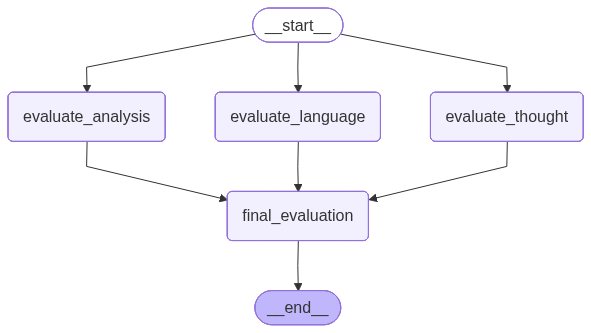

In [82]:
workflow

In [83]:
initial_state = {
    "essay": essay
}
workflow.invoke(initial_state)

{'essay': '"\nAI is all about making computers do things like think or make decisions. It’s like teaching a machine how to learn from examples. For example, when you take a picture on your phone, AI helps the camera figure out who’s in the picture, like if it sees your face, or maybe even if your dog is in it. It learns by looking at lots of data and recognizing patterns. Over time, it gets better at understanding what things are. So, just like how we learn new stuff by practicing, AI can also get better the more it’s used.\n\nAI is in a ton of stuff, even if we don’t always notice it. Some places where AI is used include phones and gadgets. Like, when you talk to Siri or Alexa, that’s AI. AI also helps make your phone camera better at taking pics and recognizing faces. It also suggests stuff you might like based on what you’ve watched or listened to before, like music or videos. Another big place AI is used is in video games. In video games, AI is used for controlling the characters y